# Predicción de la tasa de churn

## Descripción del dataset

Nuestro dataset contiene información de clientes con las siguientes columnas:

- **CustomerID**: identificador único de cada cliente.  
- **Age**: edad del cliente. Puede influir en la propensión a abandonar según segmento.  
- **Gender**: género del cliente, útil para segmentación y patrones de comportamiento.  
- **Tenure**: tiempo que el cliente lleva usando el servicio; clientes nuevos suelen tener más riesgo de churn.  
- **Usage Frequency**: frecuencia de uso del servicio; un uso bajo puede indicar riesgo de abandono.  
- **Support Calls**: número de llamadas al soporte; clientes con problemas recurrentes pueden tener mayor riesgo.  
- **Payment Delay**: retrasos en pagos; indicador financiero de riesgo de churn.  
- **Subscription Type**: tipo de suscripción contratada; ciertos planes pueden tener mayor tasa de abandono.  
- **Contract Length**: duración del contrato; contratos cortos suelen tener mayor rotación.  
- **Total Spend**: gasto total del cliente; clientes de mayor gasto pueden ser más leales.  
- **Last Interaction**: tiempo desde la última interacción con el servicio; inactividad prolongada puede indicar riesgo de churn.  
- **Churn**: variable objetivo (1 si el cliente abandonó, 0 si permanece).

Estas columnas nos permiten generar **features relevantes** para predecir la probabilidad de churn.

## Enfoque de modelado

Dado que tenemos datos históricos etiquetados, aplicaremos **aprendizaje supervisado**.  

Inicialmente probaremos **varios modelos supervisados** para comparar su desempeño y seleccionar el más adecuado. Entre ellos:

- **Logistic Regression**  
- **Decision Tree**  
- **Random Forest**  
- **K-Nearest Neighbors (KNN)**  
- **Support Vector Machine (SVM)**  
- **Gradient Boosting / LightGBM**  

Este enfoque nos permitirá obtener **predicciones de churn confiables** y estimar la probabilidad de abandono de cada cliente.


In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from math import sqrt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree, DecisionTreeClassifier, export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
warnings.filterwarnings('ignore')


## 1. Importación de paquetes y dataset

In [139]:
df_test = pd.read_csv('../data/raw/customer_churn_dataset-testing-master.csv')
df_train = pd.read_csv('../data/raw/customer_churn_dataset-training-master.csv')

## 2.EDA y Visual EDA

In [140]:
df_train.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [141]:
df_train.info()

<class 'pandas.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  str    
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  str    
 8   Contract Length    440832 non-null  str    
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), str(3)
memory usage: 40.4 MB


In [142]:
df_train.columns

Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction', 'Churn'],
      dtype='str')

In [143]:
df_train.isnull().sum()

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

In [144]:
df_test.isnull().sum()

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

In [145]:
df_train.duplicated().sum()

np.int64(0)

In [146]:
df_test.duplicated().sum()

np.int64(0)

### 2.1 Conocer las variables categóricas

In [147]:
print('Generos:\n', df_train['Gender'].unique())

Generos:
 <StringArray>
['Female', 'Male', nan]
Length: 3, dtype: str


In [148]:
print('Subscripciones:\n', df_train['Subscription Type'].unique())

Subscripciones:
 <StringArray>
['Standard', 'Basic', 'Premium', nan]
Length: 4, dtype: str


In [149]:
print('Longitud del contrato:\n', df_train['Contract Length'].unique())

Longitud del contrato:
 <StringArray>
['Annual', 'Monthly', 'Quarterly', nan]
Length: 4, dtype: str


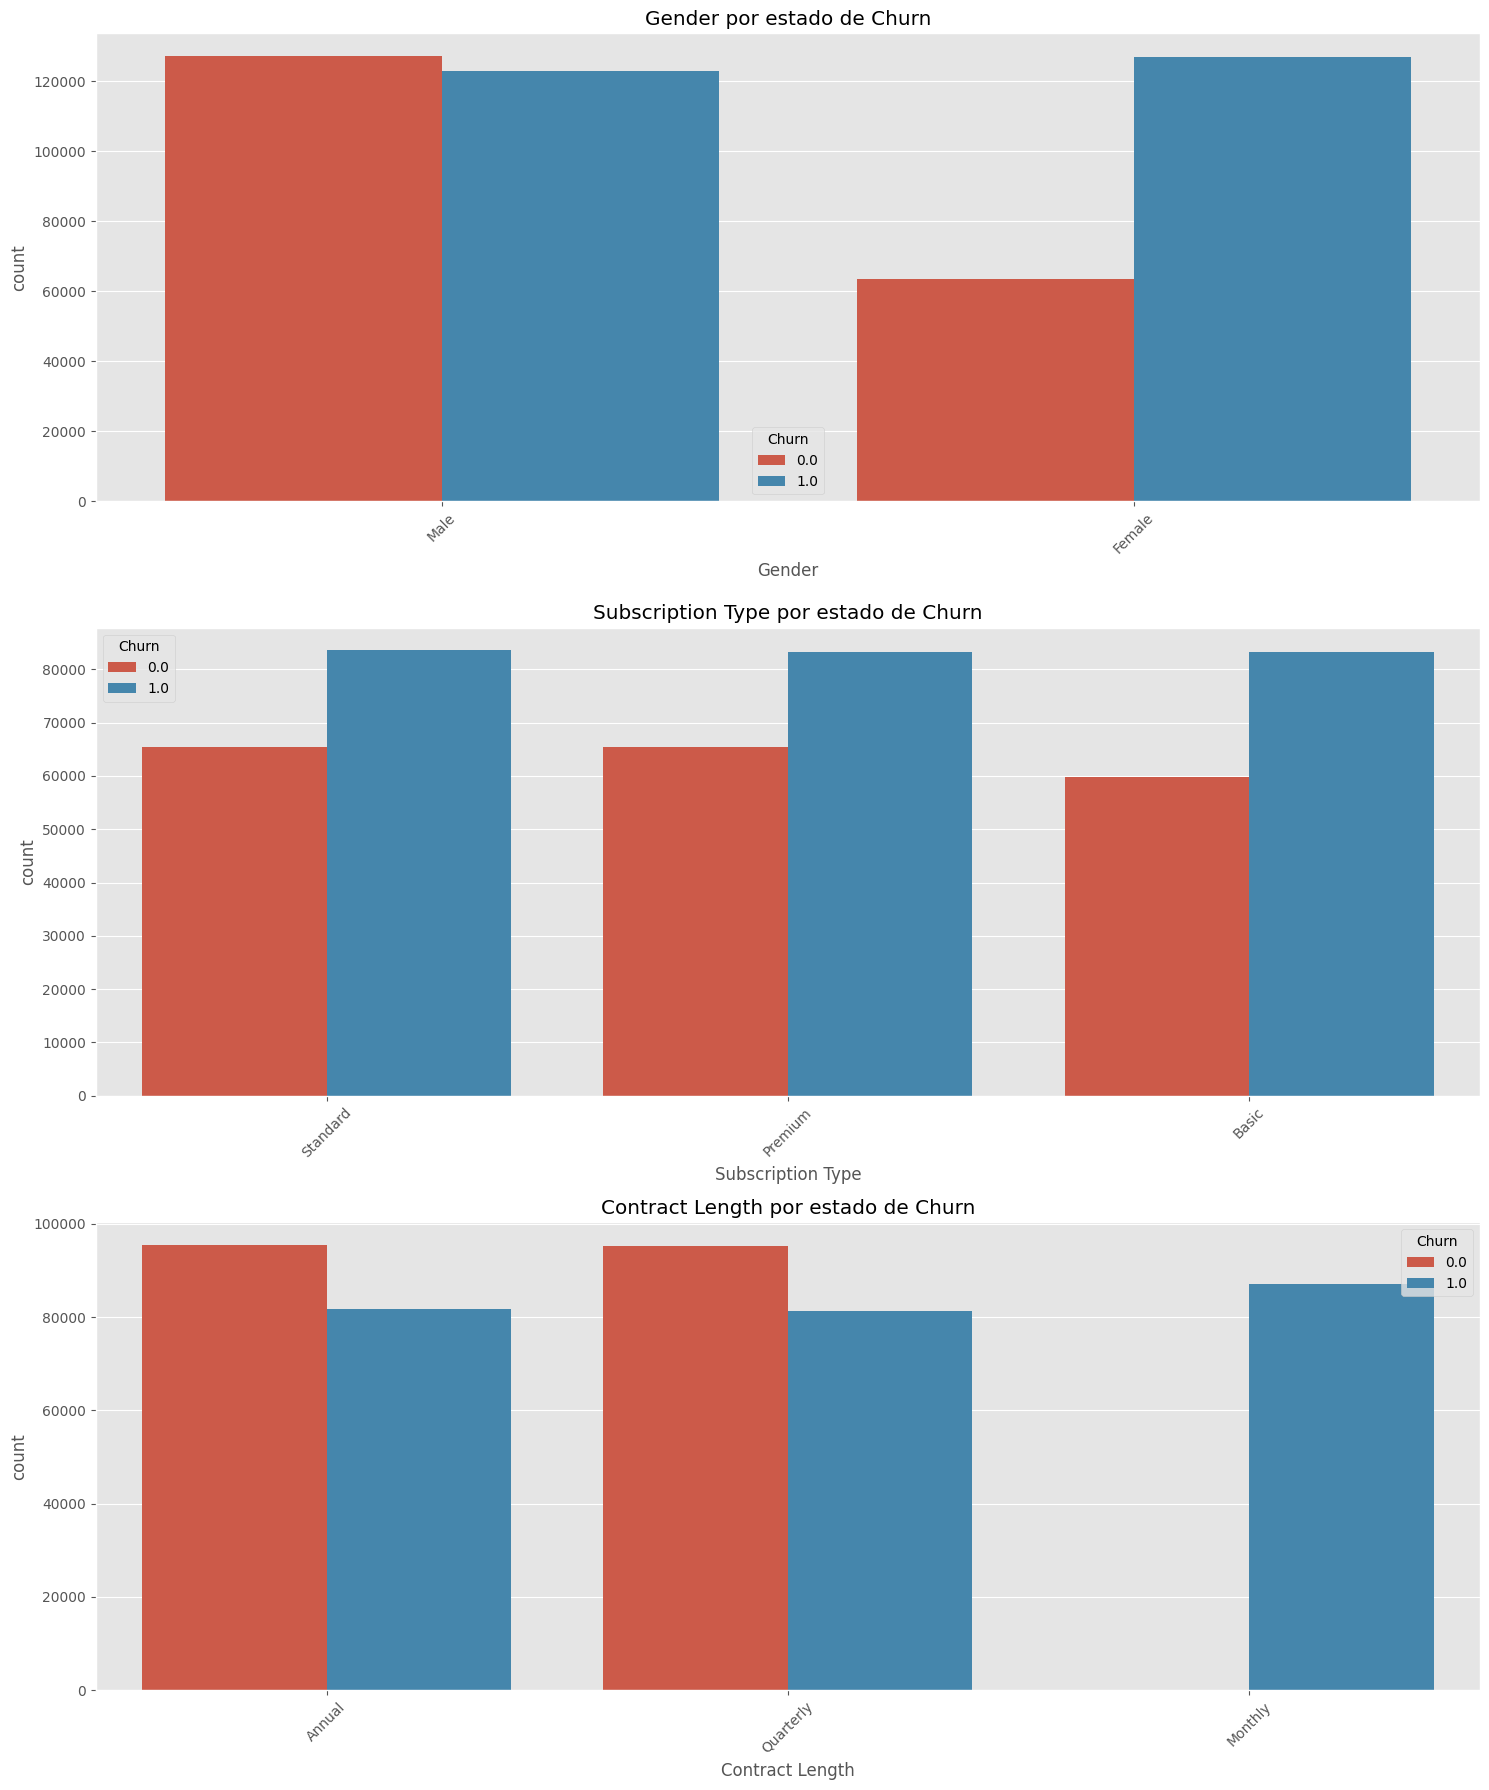

In [150]:
cat_cols = ['Gender', 'Subscription Type', 'Contract Length']

plt.figure(figsize=(15, 18))

for i, col in enumerate(cat_cols):
    plt.subplot(len(cat_cols), 1, i + 1)
    sns.countplot(
        data=df_train,
        x=col,
        hue='Churn',
        order=df_train[col].value_counts().index
    )
    plt.title(f'{col} por estado de Churn')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### 2.2 Conocer las variables numericas

#### 2.2.1 CustomerID

In [151]:
# El campo CustomerID no aporta información relevante para el análisis, por lo que no se analizara más a fondo.

#### 2.2.2 Age

In [152]:
print('Min edad: ', df_train['Age'].max())
print('Max edad: ', df_train['Age'].min())
print('Valores Nulos: ', df_train['Age'].isnull().any())

Min edad:  65.0
Max edad:  18.0
Valores Nulos:  True


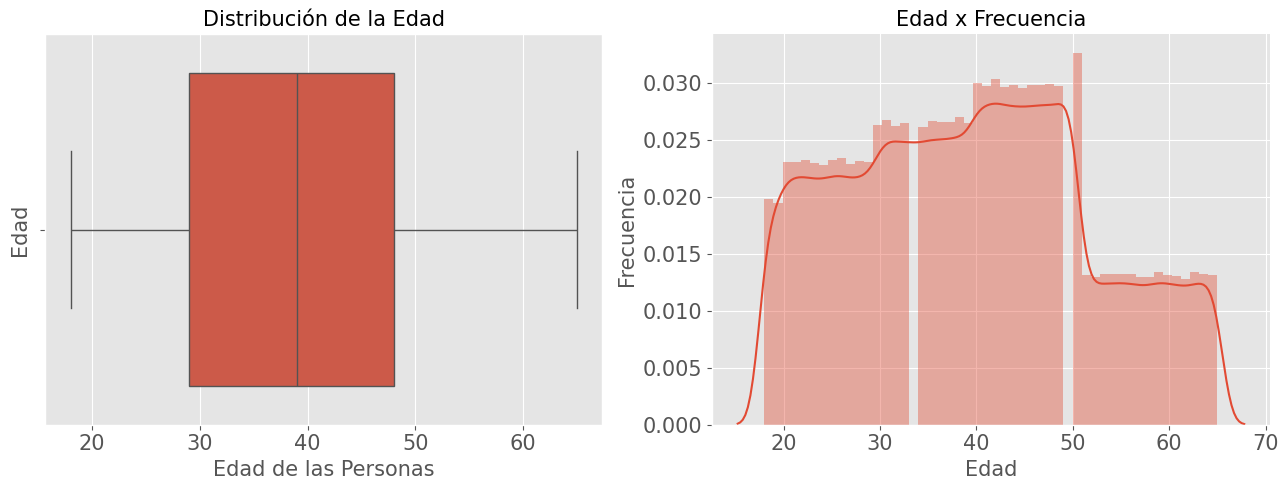

In [153]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))

# Gráfico 1: Diagrama de Caja (Boxplot)
sns.boxplot(x = 'Age', data = df_train, orient = 'v', ax = ax1)
ax1.set_xlabel('Edad de las Personas', fontsize=15)
ax1.set_ylabel('Edad', fontsize=15)
ax1.set_title('Distribución de la Edad', fontsize=15)
ax1.tick_params(labelsize=15)

# Gráfico 2: Histograma de distribución
sns.distplot(df_train['Age'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_xlabel('Edad', fontsize=15)
ax2.set_ylabel('Frecuencia', fontsize=15)
ax2.set_title('Edad x Frecuencia', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()



In [154]:
# Cuartiles
print('1º Cuartil: ', df_train['Age'].quantile(q = 0.25))
print('2º Cuartil: ', df_train['Age'].quantile(q = 0.50))
print('3º Cuartil: ', df_train['Age'].quantile(q = 0.75))
print('4º Cuartil: ', df_train['Age'].quantile(q = 1.00))

print('Edades por encima de: ', df_train['Age'].quantile(q = 0.75) + 
                      1.5*(df_train['Age'].quantile(q = 0.75) - df_train['Age'].quantile(q = 0.25)), 'son outliers')


1º Cuartil:  29.0
2º Cuartil:  39.0
3º Cuartil:  48.0
4º Cuartil:  65.0
Edades por encima de:  76.5 son outliers


In [155]:
print('Numerber of outliers: ', df_train[df_train['Age'] > 69.6]['Age'].count())
print('Number of clients: ', len(df_train))
#Outliers in %
print('Outliers are:', round(df_train[df_train['Age'] > 69.6]['Age'].count()*100/len(df_train),2), '%')


Numerber of outliers:  0
Number of clients:  440833
Outliers are: 0.0 %


In [156]:
print('MEDIA:', round(df_train['Age'].mean(), 1))

print('DESV :', round(df_train['Age'].std(), 1))

print('CV   :',round(df_train['Age'].std()*100/df_train['Age'].mean(), 1), ', Dispersión media alta')

MEDIA: 39.4
DESV : 12.4
CV   : 31.6 , Dispersión media alta


#### 2.2.3 Tenure

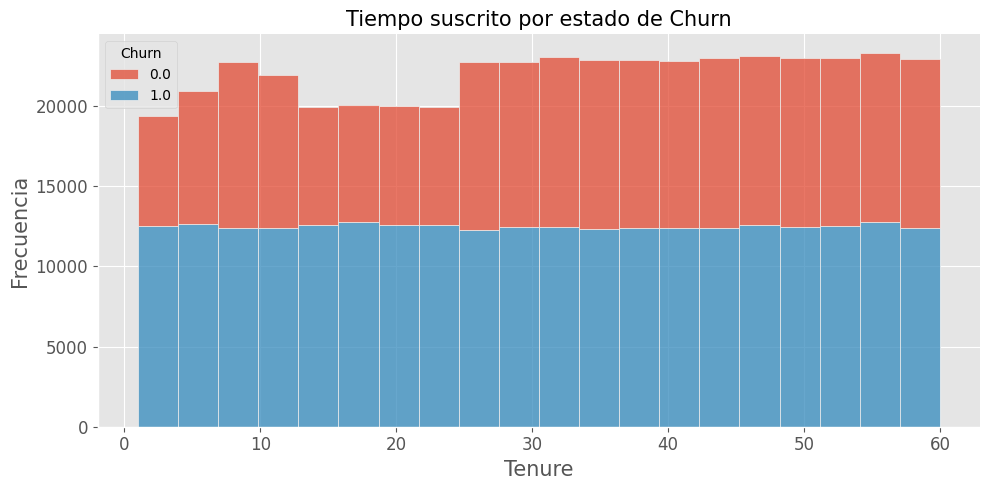

In [157]:
fig, ax = plt.subplots(figsize=(10,5))

sns.histplot(
    data=df_train,
    x='Tenure',
    hue='Churn',
    bins=20,
    multiple='stack',   # o 'layer'
    kde=False,
    ax=ax
)

ax.set_xlabel('Tenure', fontsize=15)
ax.set_ylabel('Frecuencia', fontsize=15)
ax.set_title('Tiempo suscrito por estado de Churn', fontsize=15)
ax.tick_params(labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()

#### 2.2.4 Usage Frequency

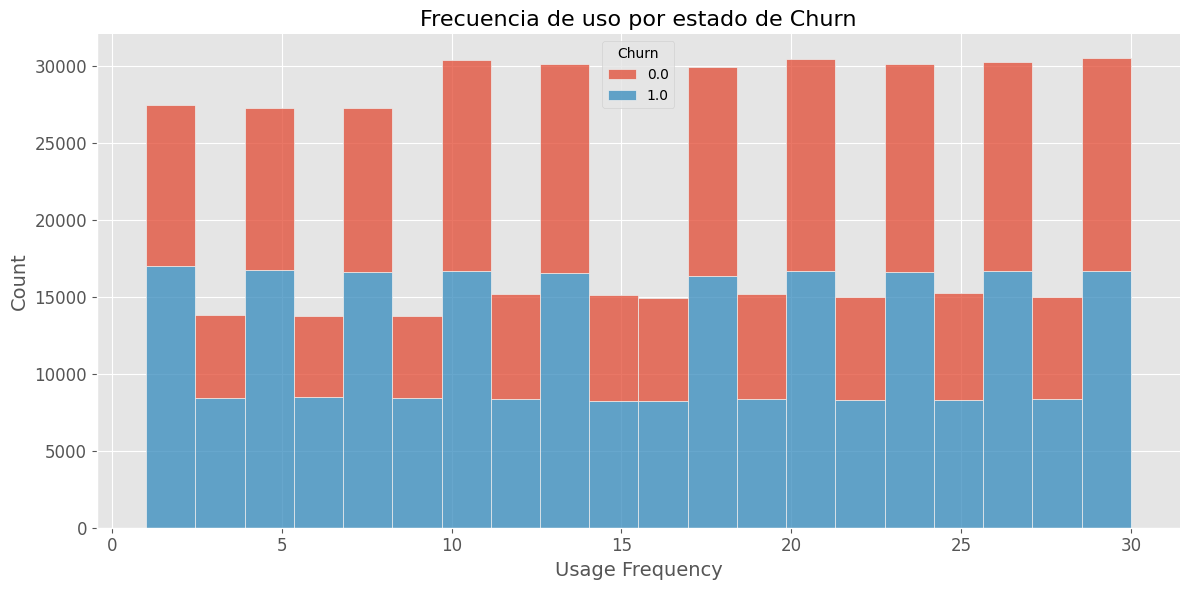

In [158]:
fig, ax = plt.subplots(figsize=(12,6))

sns.histplot(
    data=df_train,
    x='Usage Frequency',
    hue='Churn',
    bins=20,
    multiple='stack',   # usa 'layer' si quieres superposición
    kde=False,
    ax=ax
)

ax.set_xlabel('Usage Frequency', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Frecuencia de uso por estado de Churn', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()


#### 2.2.5 Support Calls

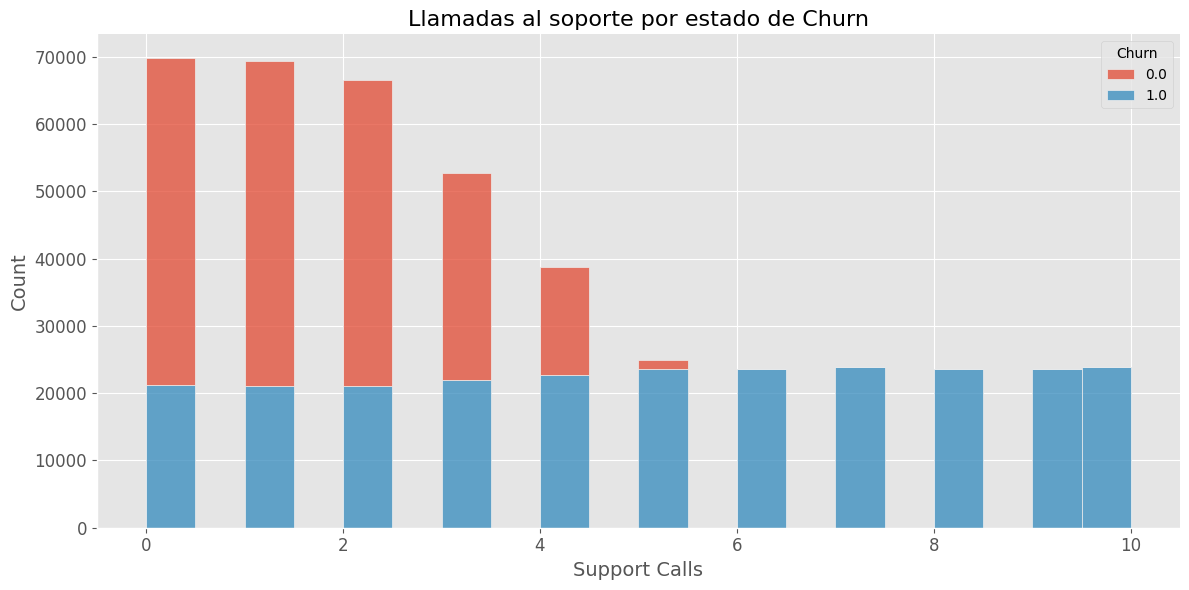

In [159]:
fig, ax = plt.subplots(figsize=(12,6))

sns.histplot(
    data=df_train,
    x='Support Calls',
    hue='Churn',
    bins=20,
    multiple='stack',   # o 'layer' si prefieres superposición
    kde=False,
    ax=ax
)

ax.set_xlabel('Support Calls', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Llamadas al soporte por estado de Churn', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()


#### 2.2.6 Payment Delay

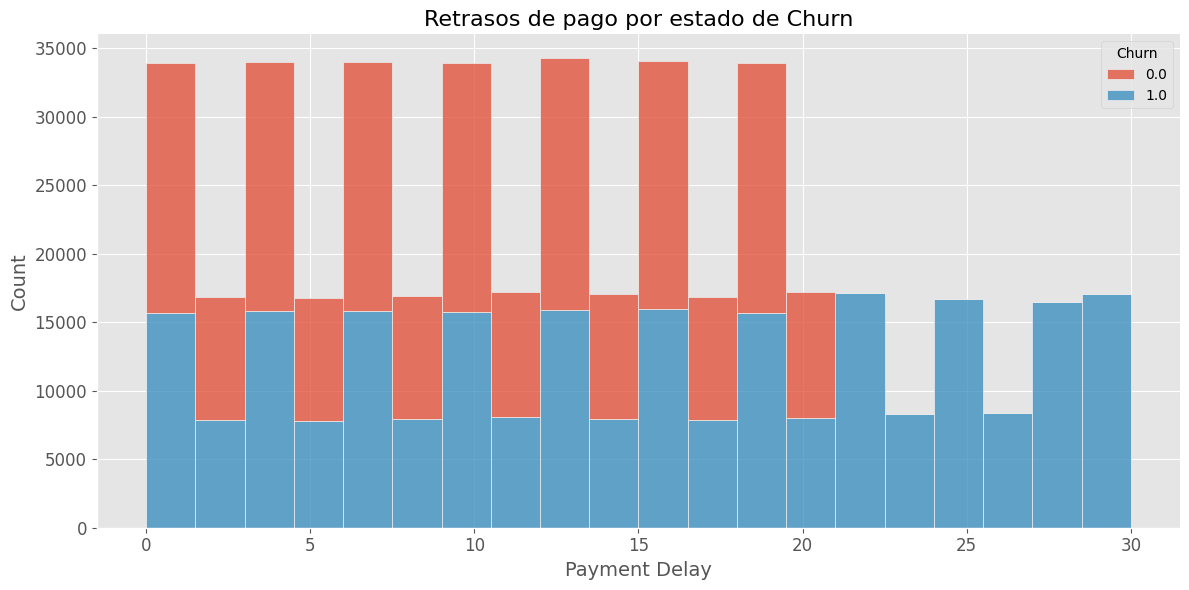

In [160]:
fig, ax = plt.subplots(figsize=(12,6))

sns.histplot(
    data=df_train,
    x='Payment Delay',
    hue='Churn',
    bins=20,
    multiple='stack',   # usa 'layer' si prefieres solapado
    kde=False,
    ax=ax
)

ax.set_xlabel('Payment Delay', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Retrasos de pago por estado de Churn', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()

#### 2.2.7 Total Spend

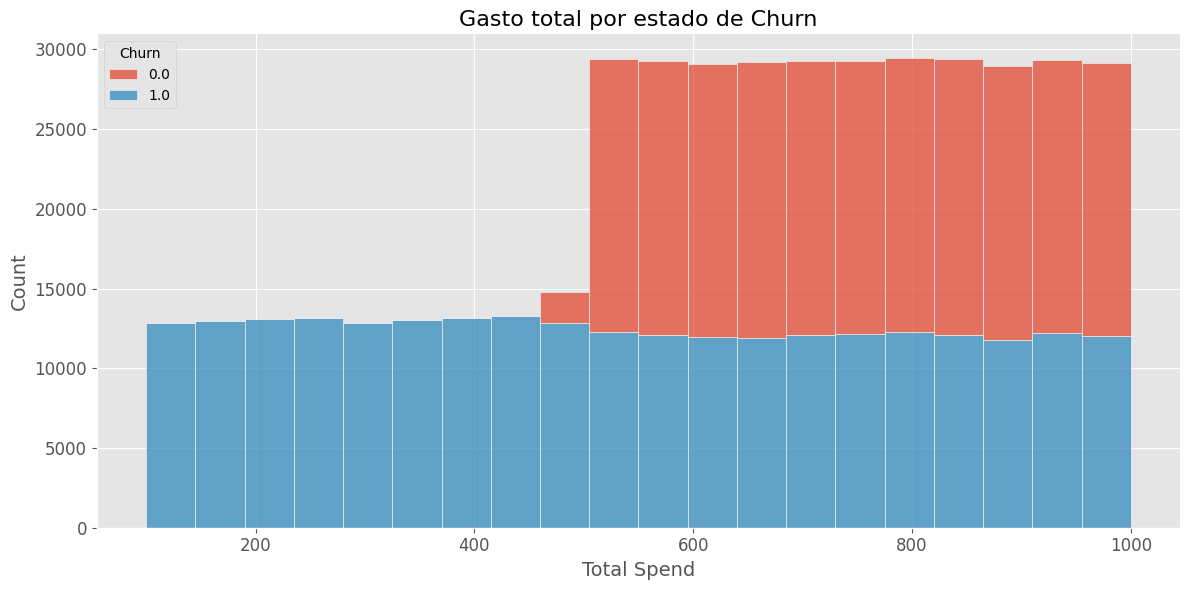

In [161]:
fig, ax = plt.subplots(figsize=(12,6))

sns.histplot(
    data=df_train,
    x='Total Spend',
    hue='Churn',
    bins=20,
    multiple='stack',   # o 'layer'
    kde=False,
    ax=ax
)

ax.set_xlabel('Total Spend', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Gasto total por estado de Churn', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()


#### 2.2.8 Last Interaction

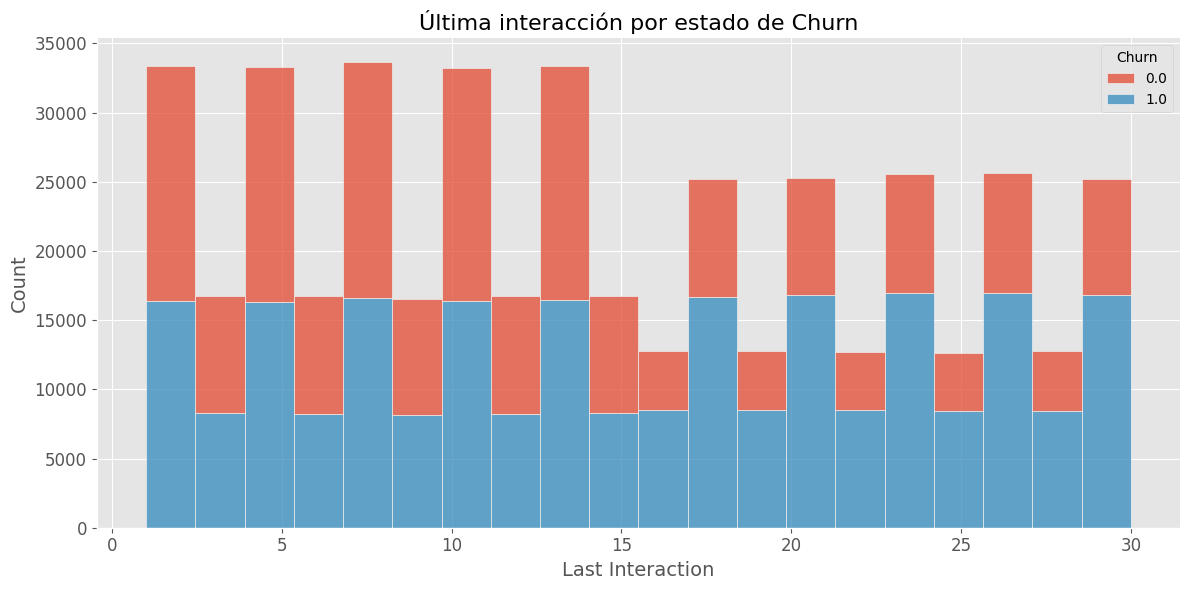

In [162]:
fig, ax = plt.subplots(figsize=(12,6))

sns.histplot(
    data=df_train,
    x='Last Interaction',
    hue='Churn',
    bins=20,
    multiple='stack',   # o 'layer'
    kde=False,
    ax=ax
)

ax.set_xlabel('Last Interaction', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Última interacción por estado de Churn', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()


#### 2.2.10 Total Churn

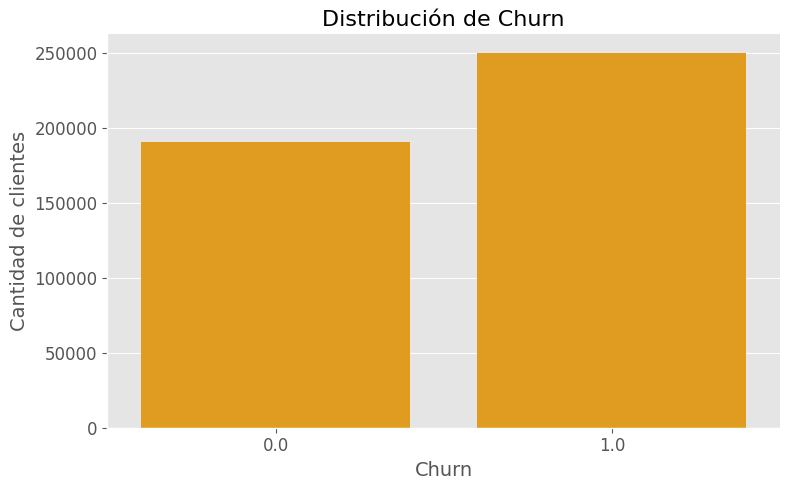

In [163]:
fig, ax = plt.subplots(figsize=(8,5))

# Countplot de Churn
sns.countplot(
    x='Churn',
    data=df_train,
    ax=ax,
    color='orange'
)

# Etiquetas y título
ax.set_xlabel('Churn', fontsize=14)
ax.set_ylabel('Cantidad de clientes', fontsize=14)
ax.set_title('Distribución de Churn', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

sns.despine()
plt.tight_layout()
plt.show()

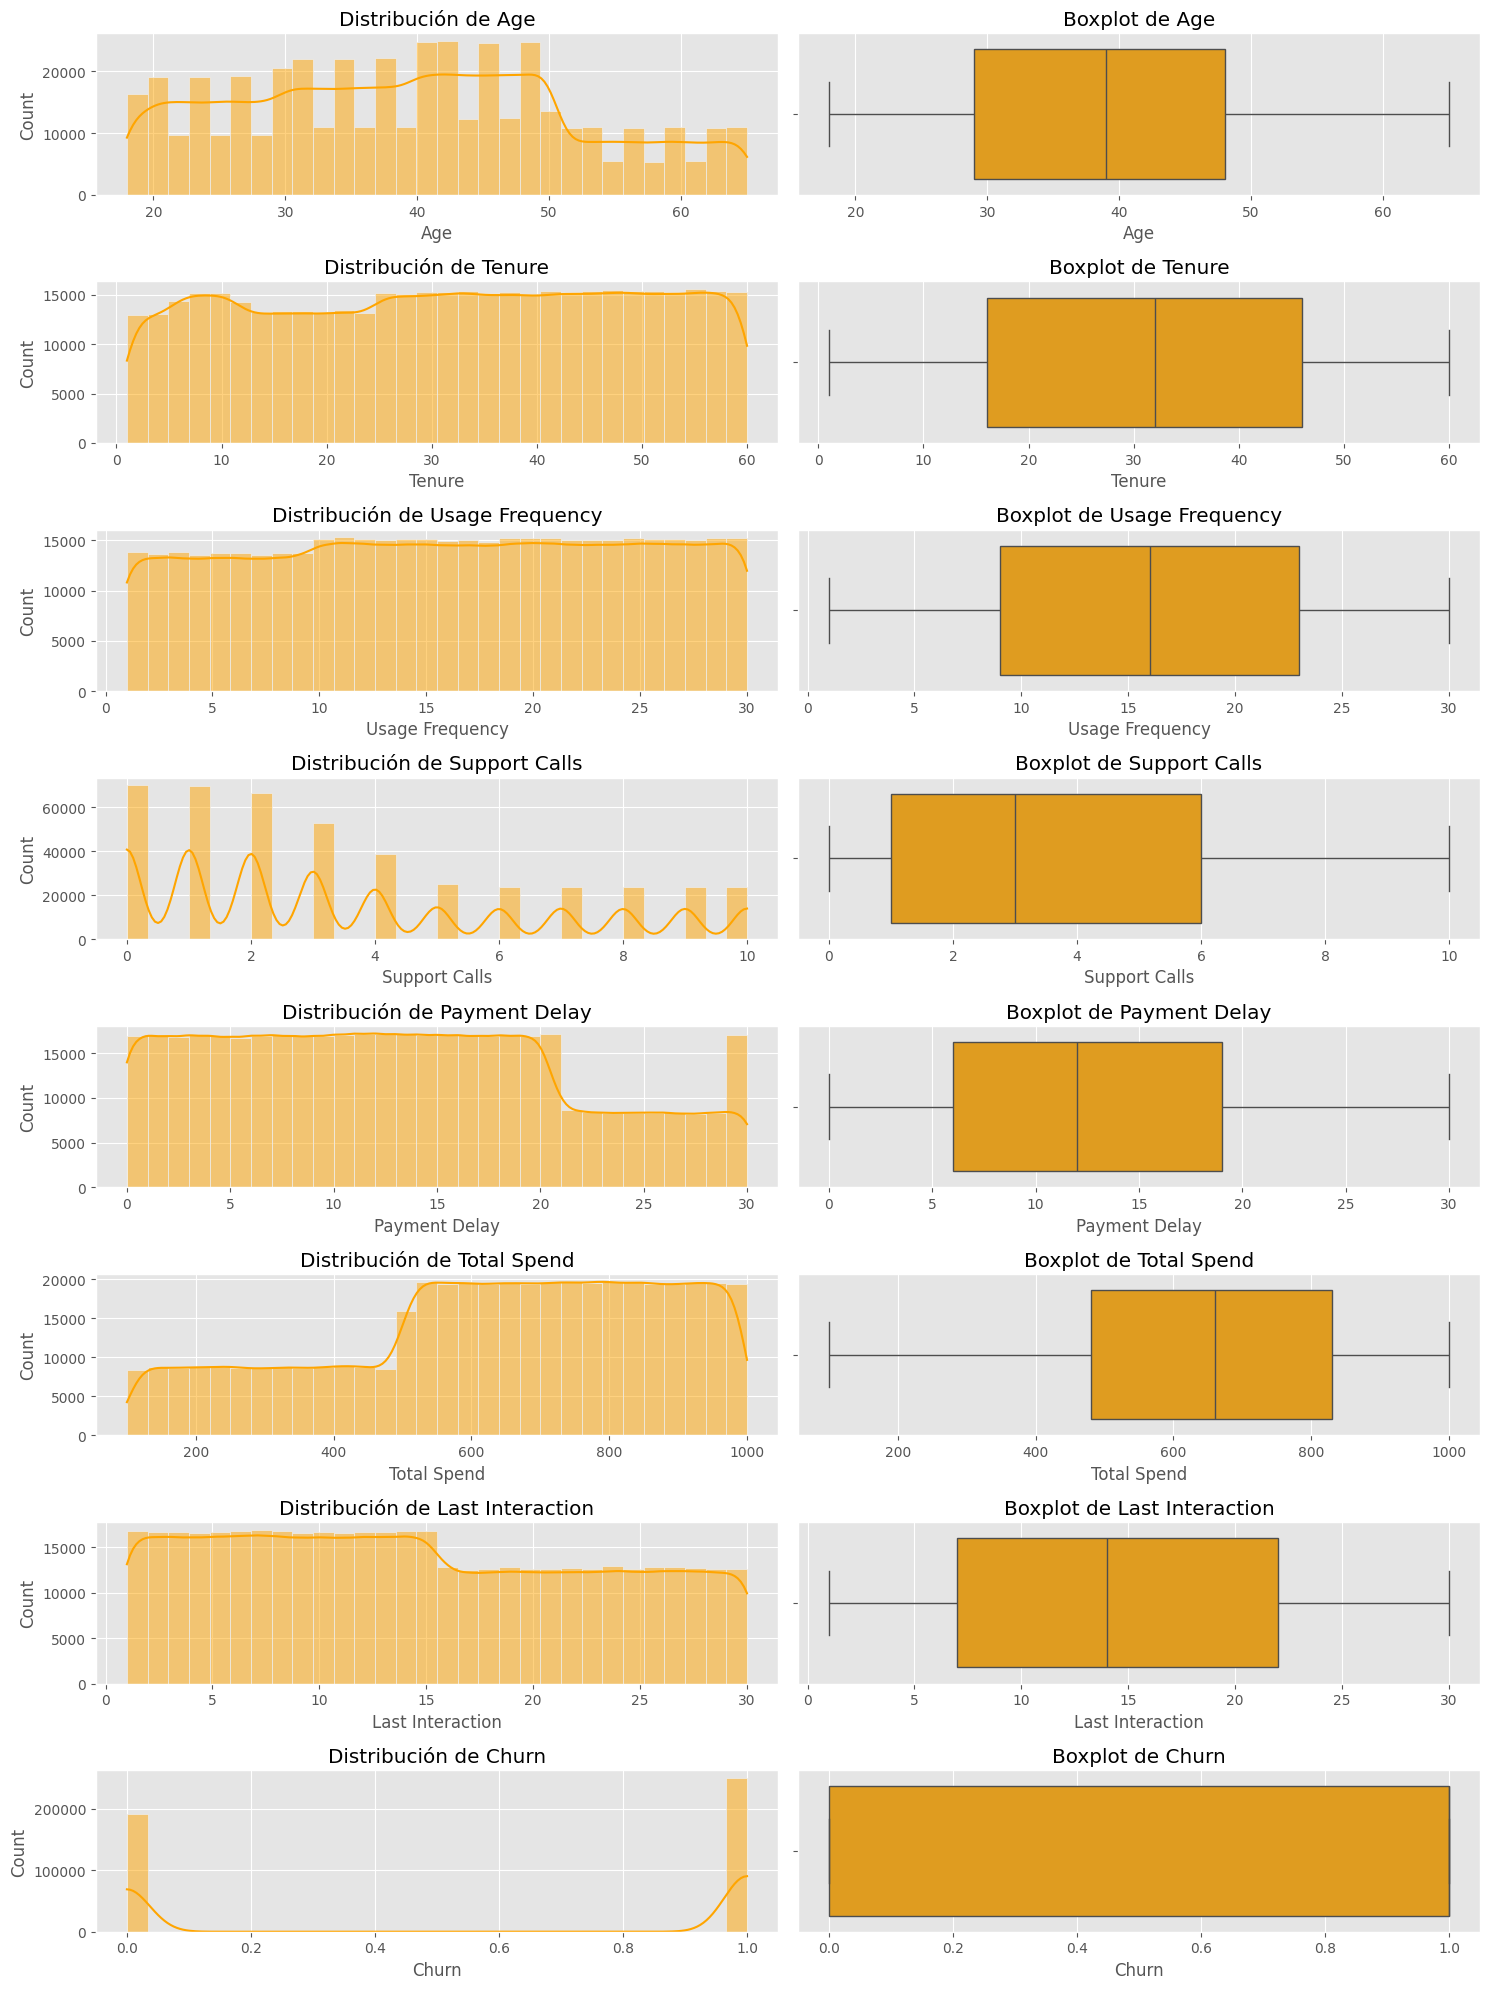

In [164]:
num_cols = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 
            'Total Spend', 'Last Interaction', 'Churn']

# Configuración de gráficos
plt.figure(figsize=(15, 20))

for i, col in enumerate(num_cols):
    # Histograma
    plt.subplot(len(num_cols), 2, 2*i + 1)
    sns.histplot(df_train[col], kde=True, bins=30, color='orange')
    plt.title(f'Distribución de {col}')
    
    # Boxplot (para ver outliers)
    plt.subplot(len(num_cols), 2, 2*i + 2)
    sns.boxplot(x=df_train[col], color='orange')
    plt.title(f'Boxplot de {col}')

plt.tight_layout()
plt.show()


### 2.2.11 Relaciones entre variables

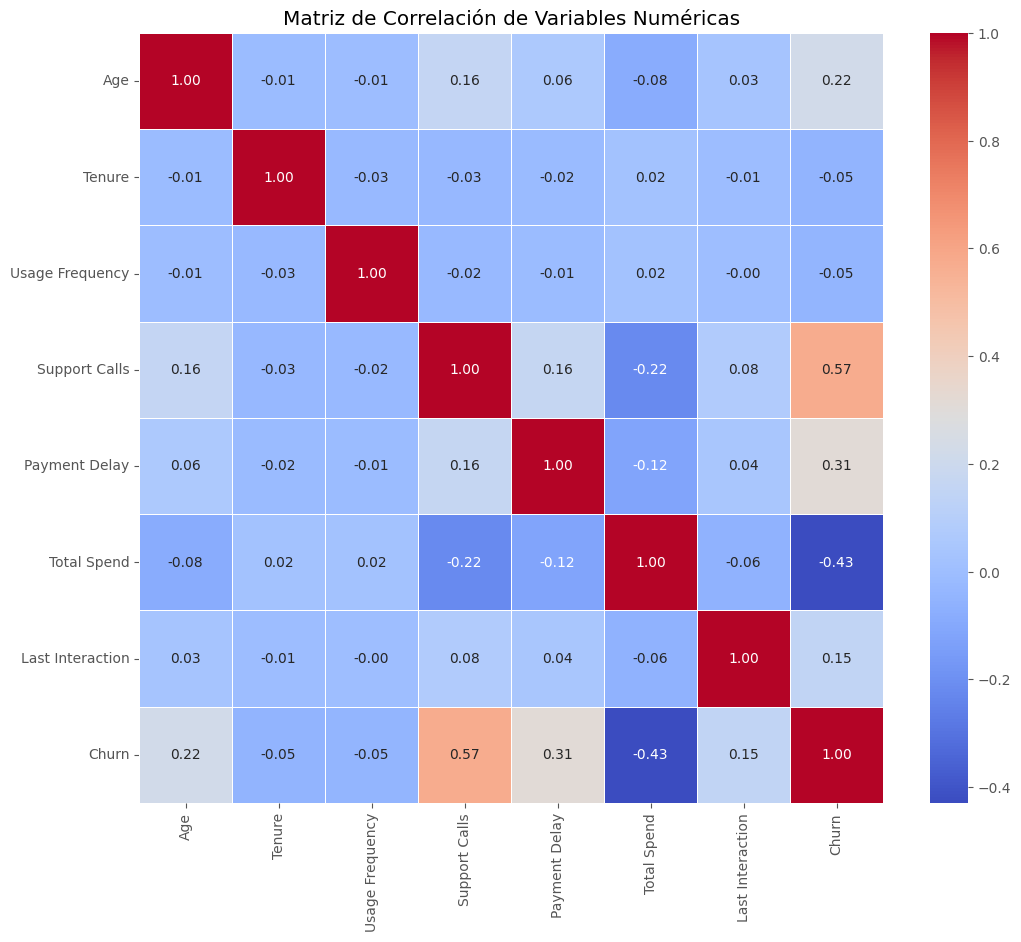

In [165]:
# Calculamos la correlación solo de las columnas numéricas
plt.figure(figsize=(12, 10))
corr_matrix = df_train[num_cols].corr()

# Heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

Son variables muy "independientes", lo cual es bueno porque aportan información única que no se solapa con los datos económicos.

## 3. Preprocessing data

In [166]:
#Debido a los pocos valores nulos que hay en el dataset, se opta por eliminar las filas que los contienen.
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [167]:
# Borrar CustomerID
df_train.drop(columns=['CustomerID'], inplace=True)
df_test.drop(columns=['CustomerID'], inplace=True)
#Borrar Usage Frequency
#Un cliente que hace churn → deja de usar el servicio Entonces su frecuencia baja brutalmente El modelo aprende: “frecuencia ≈ 0 ⇒ churn"
df_train.drop(columns=['Usage Frequency'], inplace=True)
df_test.drop(columns=['Usage Frequency'], inplace=True)
# Borrar Last Interaction Un cliente que churnea → deja de interactuar Last Interaction se vuelve enorme El modelo lo adivina sin esfuerzo
df_train.drop(columns=['Last Interaction'], inplace=True)
df_test.drop(columns=['Last Interaction'], inplace=True)
# Borrar total spend
df_train.drop(columns=['Total Spend'], inplace=True)
df_test.drop(columns=['Total Spend'], inplace=True)
# Borrar el target
df_test.drop(columns=['Churn'], inplace=True)

In [168]:
labelencoder_X = LabelEncoder()
#--------------------------Preparacion train-------------------------
df_train['Gender']            = labelencoder_X.fit_transform(df_train['Gender']) 
df_train['Subscription Type'] = df_train['Subscription Type'].str.title().map({'Basic': 0, 'Standard': 1, 'Premium': 2})
df_train['Contract Length']   = df_train['Contract Length'].str.title().map({'Monthly': 0, 'Quarterly': 1, 'Annual': 2})
#--------------------------Preparacion test--------------------------
df_test['Gender']            = labelencoder_X.fit_transform(df_test['Gender']) 
df_test['Subscription Type'] = df_test['Subscription Type'].str.title().map({'Basic': 0, 'Standard': 1, 'Premium': 2})
df_test['Contract Length']   = df_test['Contract Length'].str.title().map({'Monthly': 0, 'Quarterly': 1, 'Annual': 2})

In [169]:
df_train.isnull().any()

Age                  False
Gender               False
Tenure               False
Support Calls        False
Payment Delay        False
Subscription Type    False
Contract Length      False
Churn                False
dtype: bool

## 4. Creación del modelo y división del dataset

In [170]:
X = df_train.drop('Churn', axis=1)
y = df_train['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [171]:
print("Training set shape", X_train.shape)
print("Test set shape", X_test.shape)

Training set shape (352665, 7)
Test set shape (88167, 7)


## 5. Entrenamiento

### Knn

calculo de la mejor k

([<matplotlib.axis.XTick at 0x7ff183622c10>,
 [Text(0, 0, '0'), Text(5, 0, '5'), Text(10, 0, '10'), Text(15, 0, '15')])

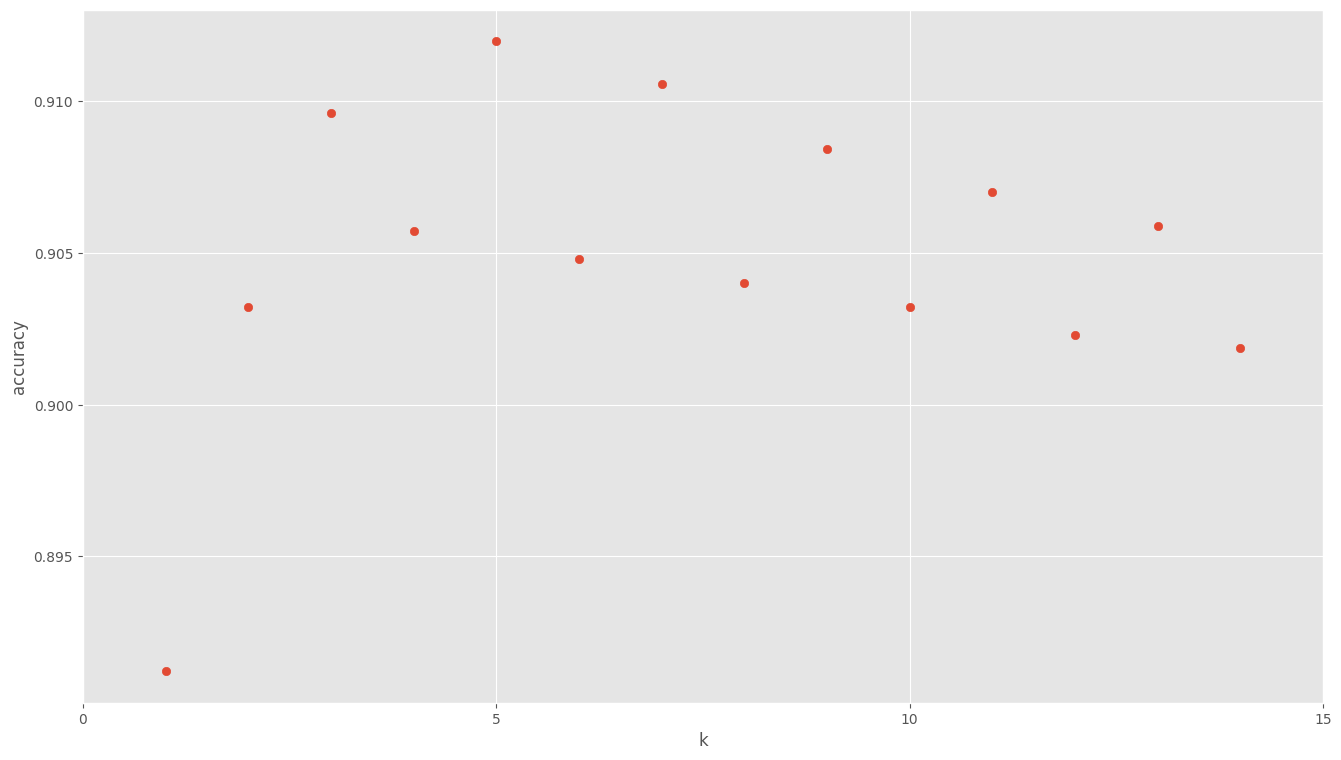

In [172]:
k_range = range(1, 15)
scores = []
for k in k_range:
      knn = KNeighborsClassifier(n_neighbors = k)
      knn.fit(X_train, y_train)
      scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15])

In [173]:
n_neighbors = 5 # busca los 5 mas cercanos

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


### LogisticRegression

In [174]:
clf = LogisticRegression(
    class_weight='balanced', 
    random_state=42

)
clf.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

### Decison Tree

Creación del modelo de Árboles de decisión

In [175]:
tree_clf = DecisionTreeClassifier(
    max_depth=5, 
    class_weight='balanced', 
    random_state=42
)

tree_clf.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

### RandomForestClassifier

In [176]:
crf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',  
    max_depth=10,
    random_state=2
)

crf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

## 6. Análisis de resultados

In [177]:
#------------------K-NN--------------------------------------
print('Score: {}'.format(knn.score(X_test, y_test)))
print('Accuracy of K-NN classifier on training set: {:.2f}'
      .format(knn.score(X_train, y_train)))#dice el resultado de el entreanmiento de knn
print('Accuracy of K-NN classifier on test set: {:.2f}'
      .format(knn.score(X_test, y_test)))#dice el resultado de el test de knn, si es ligeramente menor es que es bueno. si es malo tiene overfiting
#------------------Logistic Regresion------------------------
print('Score: {}'.format(clf.score(X_test, y_test)))
print('Accuracy of Logistic Regresion classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of Logistic Regresion classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
#------------------Decision tree classifier------------------
print('Score: {}'.format(tree_clf.score(X_test, y_test)))
print('Accuracy of Decision tree classifier on training set: {:.2f}'.format(tree_clf.score(X_train, y_train)))
print('Accuracy of Decision tree classifier on test set: {:.2f}'.format(tree_clf.score(X_test, y_test)))
#------------------Random Forest Classifier------------------
print('Score: {}'.format(crf.score(X_test, y_test)))
print("Accuracy of Random Forest Classifier on training set: {:.3f}".format(crf.score(X_train, y_train)))
print("Accuracy of Random Forest Classifier on test set: {:.3f}".format(crf.score(X_test, y_test)))

Score: 0.9119852098857849
Accuracy of K-NN classifier on training set: 0.93
Accuracy of K-NN classifier on test set: 0.91
Score: 0.8295280547143489
Accuracy of Logistic Regresion classifier on training set: 0.83
Accuracy of Logistic Regresion classifier on test set: 0.83
Score: 0.9401590164120363
Accuracy of Decision tree classifier on training set: 0.94
Accuracy of Decision tree classifier on test set: 0.94
Score: 0.9575124479680606
Accuracy of Random Forest Classifier on training set: 0.958
Accuracy of Random Forest Classifier on test set: 0.958


## 7. Realización de predicciones

### knn

In [178]:
pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))

[[37598   465]
 [ 7295 42809]]


In [179]:
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91     38063
         1.0       0.99      0.85      0.92     50104

    accuracy                           0.91     88167
   macro avg       0.91      0.92      0.91     88167
weighted avg       0.92      0.91      0.91     88167



In [180]:
print('Score: {}'.format(knn.score(X_test, y_test)))

Score: 0.9119852098857849


In [181]:
probas = knn.predict_proba(X_test)[:, 1]
predicciones_knn = (probas >= 0.7).astype(int)

predicciones_knn

array([1, 1, 1, ..., 0, 1, 0], shape=(88167,))

In [182]:
pd.Series(predicciones_knn).value_counts()

0    46916
1    41251
Name: count, dtype: int64

### LogisticRegression

In [183]:
print(confusion_matrix(y_test, (clf.predict_proba(X_test)[:, 1] >= 0.6).astype(int))) # si la probabilidad es mayor a a 0.6 devuelve True o False.

[[34904  3159]
 [12319 37785]]


In [184]:
print(classification_report(y_test, (clf.predict_proba(X_test)[:, 1] >= 0.6).astype(int)))

              precision    recall  f1-score   support

         0.0       0.74      0.92      0.82     38063
         1.0       0.92      0.75      0.83     50104

    accuracy                           0.82     88167
   macro avg       0.83      0.84      0.82     88167
weighted avg       0.84      0.82      0.83     88167



In [185]:
print('Score: {}'.format(clf.score(X_test, y_test)))

Score: 0.8295280547143489


In [186]:
probas = clf.predict_proba(df_test)[:, 1]
predicciones_clf = (probas >= 0.7).astype(int)
predicciones_clf

array([1, 1, 0, ..., 1, 1, 1], shape=(64374,))

In [187]:
pd.Series(predicciones_clf).value_counts()

1    47974
0    16400
Name: count, dtype: int64

### Decision Tree

In [188]:
print(confusion_matrix(y_test, (tree_clf.predict_proba(X_test)[:, 1] >= 0.7).astype(int))) # si la probabilidad es mayor a a 0.7 devuelve True o False.

[[38063     0]
 [ 5276 44828]]


In [189]:
print(classification_report(y_test, (tree_clf.predict_proba(X_test)[:, 1] >= 0.7).astype(int)))

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94     38063
         1.0       1.00      0.89      0.94     50104

    accuracy                           0.94     88167
   macro avg       0.94      0.95      0.94     88167
weighted avg       0.95      0.94      0.94     88167



In [190]:
print('Score: {}'.format(tree_clf.score(X_test, y_test)))

Score: 0.9401590164120363


In [191]:
probas = tree_clf.predict_proba(df_test)[:, 1]
predicciones_tree_clf = (probas >= 0.7).astype(int)
predicciones_tree_clf

array([1, 1, 1, ..., 1, 1, 1], shape=(64374,))

In [192]:
pd.Series(predicciones_tree_clf).value_counts()

1    57774
0     6600
Name: count, dtype: int64

### Random Forest Classifier

In [193]:
print(confusion_matrix(y_test, crf.predict(X_test)))

[[38062     1]
 [ 3745 46359]]


In [194]:
print(classification_report(y_test, crf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     38063
         1.0       1.00      0.93      0.96     50104

    accuracy                           0.96     88167
   macro avg       0.96      0.96      0.96     88167
weighted avg       0.96      0.96      0.96     88167



In [195]:
probas = crf.predict_proba(df_test)[:, 1]
predicciones_crf = (probas >= 0.7).astype(int)
predicciones_crf

array([1, 1, 1, ..., 1, 1, 1], shape=(64374,))

In [196]:
pd.Series(predicciones_crf).value_counts()

1    58272
0     6102
Name: count, dtype: int64

## 8. Visualización

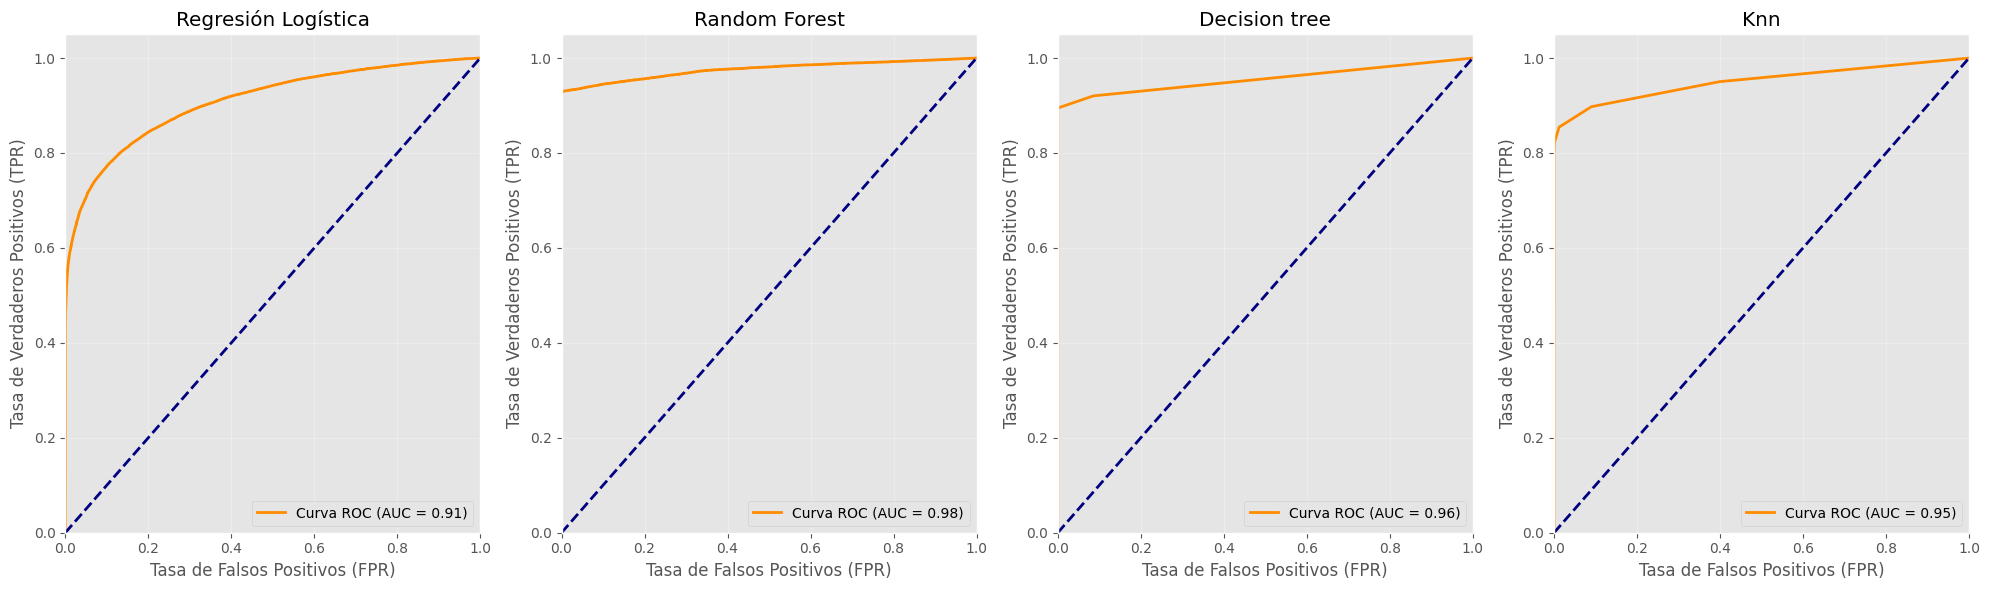

In [199]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

models = [
    ('Regresión Logística', clf),
    ('Random Forest', crf),
    ('Decision tree', tree_clf),
    ('Knn', knn),
]

for ax, (nombre, modelo) in zip(axes, models):
    
    y_probs = modelo.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Línea base aleatoria
    
    # Decoración del gráfico
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Tasa de Falsos Positivos (FPR)')
    ax.set_ylabel('Tasa de Verdaderos Positivos (TPR)')
    ax.set_title(f'{nombre}')
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

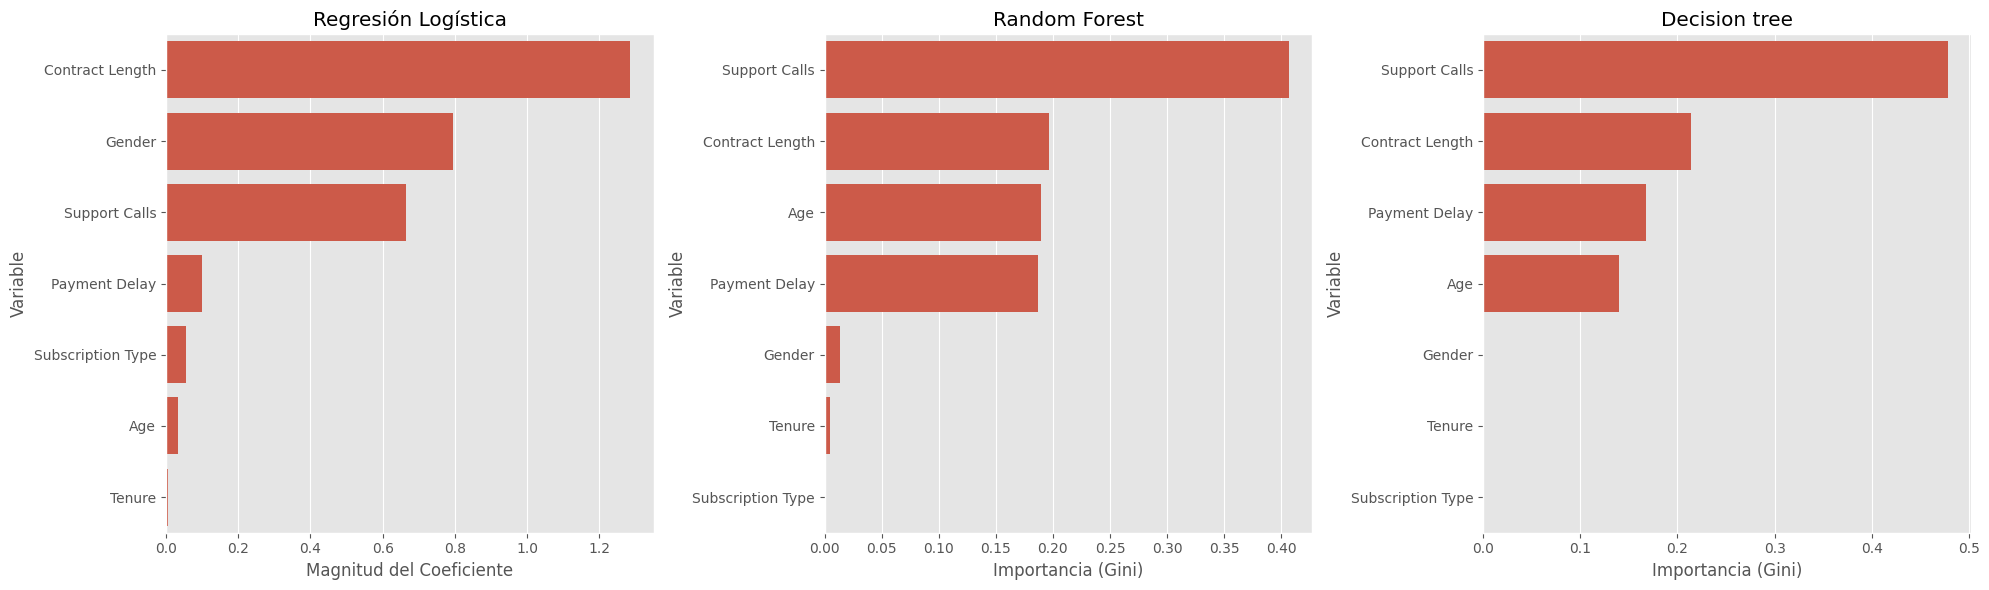

In [202]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

models = [
    ('Regresión Logística', clf),
    ('Random Forest', crf),
    ('Decision tree', tree_clf)
]

feature_names = X.columns

for ax, (nombre, modelo) in zip(axes, models):

    # Random Forest
    if hasattr(modelo, 'feature_importances_'):
        importances = modelo.feature_importances_
        xlabel = 'Importancia (Gini)'

    # Regresión Logística y SVM lineal
    elif hasattr(modelo, 'coef_'):
        importances = np.abs(modelo.coef_[0])
        xlabel = 'Magnitud del Coeficiente'

    else:
        raise ValueError(f'El modelo {nombre} no permite calcular importancias')

    feature_imp_df = (
        pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        .sort_values(by='Importance', ascending=False)
    )

    sns.barplot(
        x='Importance',
        y='Feature',
        data=feature_imp_df,
        ax=ax
    )

    ax.set_title(nombre)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Variable')

plt.tight_layout()
plt.show()

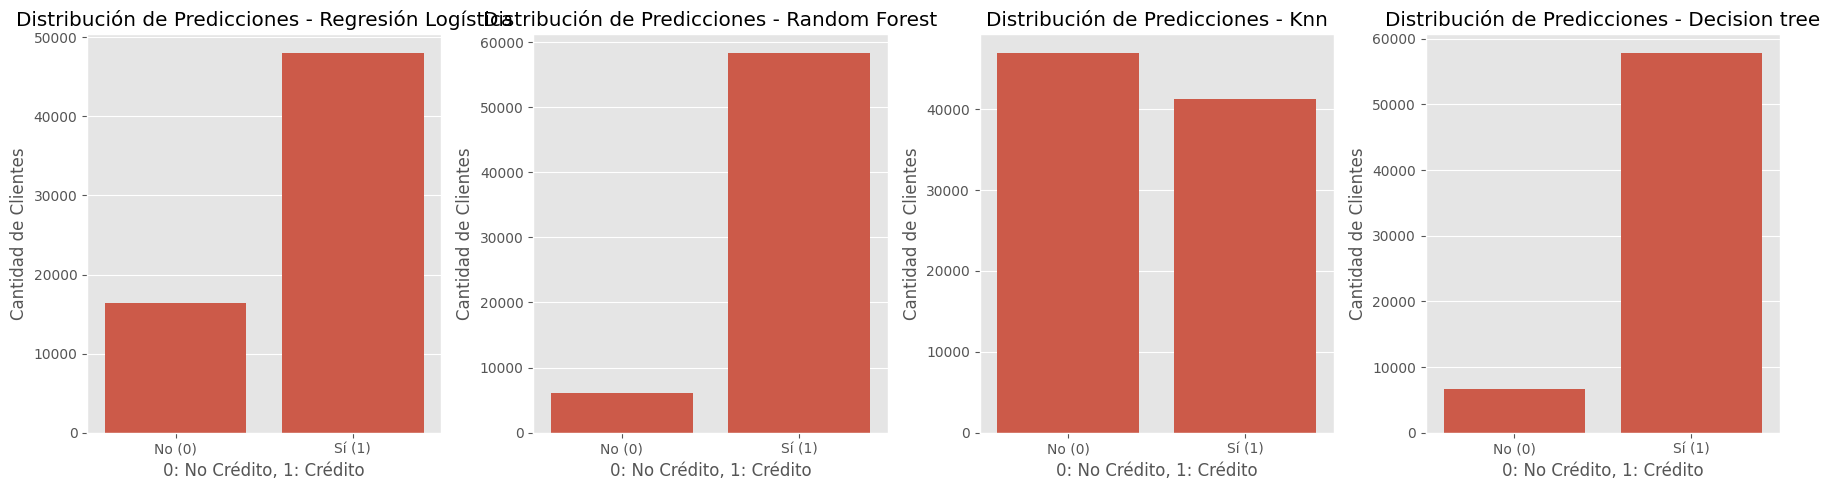

In [204]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

predicciones = [
    ('Regresión Logística', predicciones_clf),
    ('Random Forest', predicciones_crf),
    ('Knn', predicciones_knn),
    ('Decision tree', predicciones_tree_clf),
]

for ax, (nombre, preds) in zip(axes, predicciones):

    sns.countplot(x=preds, ax=ax)

    ax.set_title(f'Distribución de Predicciones - {nombre}')
    ax.set_xlabel('0: No Crédito, 1: Crédito')
    ax.set_ylabel('Cantidad de Clientes')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No (0)', 'Sí (1)'])

plt.tight_layout()
plt.show()